# Face classifier - Baseline Model

## Set up

In [1]:
# Stdlib imports
from pathlib import Path
from datetime import datetime as dt

# 3rd party imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score

# Local imports
from facecls import fcaux

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [3]:
target = "gender"
model_type = "logreg" 

In [4]:
models_dir = Path(f"results/models/{target.title()}Classifier/")

try:
    last_model_id = max([int(folder.as_posix().split("_")[2]) for folder in models_dir.glob(f'{model_type}*')])
except ValueError:
    last_model_id = 0

print("Last model id:", last_model_id)

new_model_id = last_model_id + 1
file_suffix = f"{model_type}_{target}_{str(new_model_id).zfill(3)}"
new_model_dir = models_dir / file_suffix
print(f"Creating folder \"{new_model_dir}\"...")
new_model_dir.mkdir(parents=True, exist_ok=True)

Last model id: 0
Creating folder "results/models/GenderClassifier/logreg_gender_001"...


## Load data

In [5]:
data = pd.read_csv("data/age_gender_preproc.csv")

## Baseline model 1: Logistic Regression

In [6]:
full_img_vec_list = np.array([fcaux.pxlstring2pxlvec(data, i) for i in range(data.shape[0])])

#### Data split

In [7]:
indeces = list(range(len(full_img_vec_list)))

In [8]:
if "age" in target and not(target == "age_cat"):
    idx_train, idx_test = train_test_split(indeces,
                                           test_size = 0.2,
                                           random_state=seed)
    idx_train, idx_val  = train_test_split(idx_train,
                                           test_size = 0.1,
                                           random_state=seed)

    X_train = full_img_vec_list[idx_train]
    y_train = data[target].values[idx_train]
    X_val = full_img_vec_list[idx_val]
    y_val = data[target].values[idx_val]
    X_test = full_img_vec_list[idx_test]
    y_test = data[target].values[idx_test]
    test_attrs = data[["age", "ethnicity", "gender"]].iloc[idx_test]

else:
    idx_train, idx_test = train_test_split(indeces, 
                                           test_size = 0.2,
                                           stratify = data[target].values,
                                           random_state=seed
                                           )

    idx_train, idx_val  = train_test_split(idx_train, 
                                           test_size = 0.1,
                                           stratify = data[target].values[idx_train],
                                           random_state=seed
                                           )

    X_train = full_img_vec_list[idx_train]
    y_train = data[target].values[idx_train]
    X_val = full_img_vec_list[idx_val]
    y_val = data[target].values[idx_val]
    X_test = full_img_vec_list[idx_test]
    y_test = data[target].values[idx_test]
    test_attrs = data[["age", "ethnicity", "gender"]].iloc[idx_test]

In [9]:
print("#training:", len(X_train))
print("#validation:", len(X_val))
print("#test:", len(X_test))

#training: 17067
#validation: 1897
#test: 4741


In [10]:
idx_val += (len(idx_train) - len(idx_val))*[np.nan]
idx_test += (len(idx_train) - len(idx_test))*[np.nan]

assert len(idx_train) == len(idx_val)
assert len(idx_train) == len(idx_test)

idx_df = pd.DataFrame({"train_idx": idx_train,
                       "val_idx": idx_val,
                       "test_idx": idx_test}, dtype="Int64")

idx_df.to_csv(new_model_dir / f"data_set_indices__{file_suffix}.csv", index=False)

In [11]:
model = LogisticRegression(random_state = seed, 
                           #solver="liblinear",
                           n_jobs = -1,
                           verbose=True
                           )

start = dt.now()
model.fit(X_train, y_train)
elapsed = dt.now()-start
print(f"Elapsed: {elapsed}s")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2305     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.04088D+01


 This problem is unconstrained.



At iterate   50    f=  3.47158D-01    |proj g|=  5.23641D-01

At iterate  100    f=  3.23691D-01    |proj g|=  2.70432D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2305    100    115      1     0     0   2.704D-01   3.237D-01
  F =  0.32369066940034658     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Elapsed: 0:00:06.566857s


/Users/mischaknabenhans/Desktop/LEARNING/Lectures/OnlineLectures/Coursera/DL_and_RL/FaceClassifier/face_cls_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model = RandomForestClassifier(random_state = seed,
                               n_jobs = -1,
                               verbose=True
                               )

param_dist = {"n_estimators": [10,50,100,200,500,1000],
              "max_depth": [1,2,3,4,5]
             }

rand_search = RandomizedSearchCV(model,
                                 param_distributions = param_dist,
                                 cv = 5,
                                 n_iter = 10,
                                 random_state = seed, 
                                 n_jobs = -1,
                                 verbose = True 
                                )

start = dt.now()
rand_search.fit(X_train, y_train)
elapsed = dt.now()-start
print(f"Elapsed: {elapsed}s")

In [ ]:
model = rand_search.best_estimator_

In [12]:
y_prob_test = model.predict_proba(X_test)

In [13]:
fpr, tpr, thr = roc_curve(y_test, y_prob_test[:,1])
pd.DataFrame({"FPR": fpr, "TPR": tpr}).to_csv(new_model_dir / f"fpr_vs_tpr__{file_suffix}.csv")

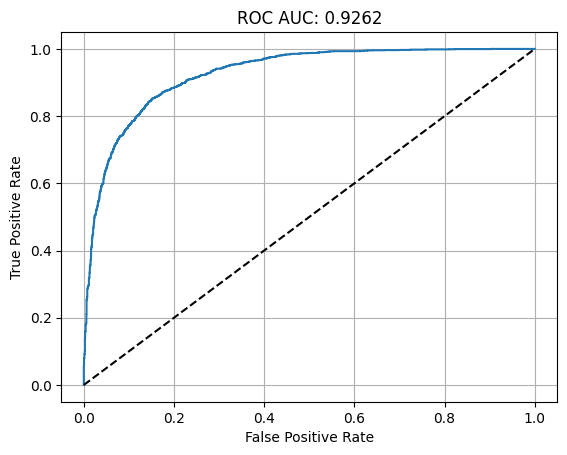

In [14]:
fig, ax = plt.subplots()
ax.plot(fpr,tpr)
ax.plot([0,1], [0,1], ls="--", c="k")
ax.grid(True)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC AUC: {np.round(roc_auc_score(y_test, y_prob_test[:,1]),4)}")
plt.savefig(new_model_dir / f"roc_curve__{file_suffix}.png",
            bbox_inches='tight')
plt.show()

In [15]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

y_proba_train = model.predict_proba(X_train)
y_proba_val = model.predict_proba(X_val)
y_proba_test = model.predict_proba(X_test)

In [16]:
cls_report = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))
cls_report.to_csv(new_model_dir / f"classificationo_report__{file_suffix}.csv")

In [18]:
train_metrics = {"accuracy": accuracy_score(y_train, y_pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, y_pred_train),
                "roc_auc": roc_auc_score(y_train, y_proba_train[:,1]),
                "F1": f1_score(y_train, y_pred_train)}

val_metrics = {"accuracy": accuracy_score(y_val, y_pred_val),
                "balanced_accuracy": balanced_accuracy_score(y_val, y_pred_val),
                "roc_auc": roc_auc_score(y_val, y_proba_val[:,1]),
                "F1": f1_score(y_val, y_pred_val)}

test_metrics = {"accuracy": accuracy_score(y_test, y_pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_test),
                "roc_auc": roc_auc_score(y_test, y_proba_test[:,1]),
                "F1": f1_score(y_test, y_pred_test)}

metrics_df = pd.DataFrame({"train": train_metrics, 
                           "val": val_metrics, 
                           "test": test_metrics})

display(metrics_df)
metrics_df.to_csv(new_model_dir / f"metrics__{file_suffix}.csv")

,train,val,test
accuracy,0.863362,0.862414,0.849610
balanced_accuracy,0.863192,0.862294,0.849309
roc_auc,0.936254,0.935955,0.926166
F1,0.857230,0.856357,0.842501


In [ ]:
base_best_params = pd.DataFrame({k: str(v) for k,v in rand_search.best_params_.items()}, index=[0])
base_best_params.to_csv(new_model_dir / f"best_params__{file_suffix}.csv", index=False)